## VAR

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR


# Load the data from the CSV file
df = pd.read_csv('./munich_erhardt.csv')

# Display the first few rows of the data
print(df.head())

# Convert the 'Date' column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Since we are interested in forecasting with VAR, we'll focus on the numerical columns that are likely to have interdependencies
# For simplicity, let's start with Total, AvgTemp, and RainfallVolume. Additional variables can be added to the model as needed
df_var = df[['Total', 'AvgTemp', 'RainfallVolume']]

# Check for missing values
missing_values = df_var.isnull().sum()

missing_values

# The selected variables (Total, AvgTemp, and RainfallVolume) have no missing values, which simplifies the preprocessing step. 
#
# Next, we'll test for stationarity with the Augmented Dickey-Fuller (ADF) test for each of these variables. 
# It's crucial that our time series data is stationary to use VAR modeling effectively. Let's proceed with the stationarity tests.

# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series.dropna(), autolag='AIC')  # dropna() handles any NaN values that might affect the test
    print(f'  ADF Statistic: {result[0]}')
    print(f'  p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'  Critical Value {key}: {value}')
    
    if result[1] <= 0.05:
        print("  => P-value <= 0.05. The series is stationary.\n")
    else:
        print("  => P-value > 0.05. The series is not stationary.\n")

# Perform ADF test on each selected variable
for col in df_var.columns:
    adf_test(df_var[col], title=col)
    
# Next, we'll create a Vector Autoregression (VAR) model with these variables. 
# We'll first determine the optimal number of lags to use for the VAR model by using the model's select_order method and then fit the model with the optimal lag length. 

# Instantiate the VAR model
model = VAR(df_var)

# Select the optimal lag order with Akaike Information Criterion (AIC)
lag_order = model.select_order(maxlags=15)
print(lag_order.summary())

# Fit the VAR model using the optimal lag order determined by AIC
# Assuming the AIC suggests the best lag, we use it; otherwise, adjust accordingly
optimal_lag = lag_order.aic

# Fit the model
results = model.fit(optimal_lag)
print(results.summary())

         Date   Total  MinTemp  MaxTemp  RainfallVolume  AvgTemp  DayOfWeek  \
0  2011-07-25  1823.0      6.9     19.0             0.0     13.0          1   
1  2011-07-26  6167.0      8.1     22.7             0.0     15.4          2   
2  2011-07-27  6294.0      8.0     24.4             0.0     16.2          3   
3  2011-07-28  3943.0     12.9     23.7            31.0     18.3          4   
4  2011-07-29  3562.0     14.5     22.2             5.2     18.4          5   

   Month  Year  
0      7  2011  
1      7  2011  
2      7  2011  
3      7  2011  
4      7  2011  
ADF Test on "Total"
  ADF Statistic: -4.4576142107782095
  p-value: 0.00023438394614298713
  Critical Value 1%: -3.4317998168351687
  Critical Value 5%: -2.8621806470517406
  Critical Value 10%: -2.5671110198147815
  => P-value <= 0.05. The series is stationary.

ADF Test on "AvgTemp"
  ADF Statistic: -4.2871478843106985
  p-value: 0.0004675355604961274
  Critical Value 1%: -3.4317962896362406
  Critical Value 5%: -2.86

/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        21.92       21.93   3.321e+09       21.92
1        19.03       19.04   1.830e+08       19.03
2        18.96       18.99   1.719e+08       18.97
3        18.95       18.99   1.693e+08       18.96
4        18.93       18.98   1.656e+08       18.94
5        18.90       18.97   1.616e+08       18.92
6        18.84       18.93   1.528e+08       18.87
7        18.80      18.89*   1.463e+08       18.83
8        18.79       18.90   1.452e+08       18.83
9        18.79       18.91   1.445e+08      18.83*
10       18.79       18.92   1.447e+08       18.84
11       18.79       18.94   1.449e+08       18.84
12       18.79       18.95   1.446e+08       18.84
13       18.78       18.95   1.432e+08       18.84
14       18.77       18.95   1.414e+08       18.83
15      18.77*       18.96  1.412e+08*       18.83
-------------------------------

In [13]:
# Forecasting the next X steps
forecast_steps = 10
forecast = results.forecast(df_var.values[-optimal_lag:], steps=forecast_steps)

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df_var.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=df_var.columns)

# Display the forecast
print(forecast_df)

                  Total   AvgTemp  RainfallVolume
2024-01-01  1388.434322  4.835062        1.418264
2024-01-02  1980.761297  5.266536        0.642243
2024-01-03  1958.607790  5.655668        1.309970
2024-01-04  2044.502858  5.706786        1.771951
2024-01-05  1955.492748  5.836784        2.306306
2024-01-06  1795.795218  5.621358        1.829262
2024-01-07  1573.450779  5.537557        1.763706
2024-01-08  1585.366143  5.621867        1.839449
2024-01-09  1645.781451  5.679420        2.083967
2024-01-10  1747.844417  5.559063        2.015149


Total             0
AvgTemp           0
RainfallVolume    0
dtype: int64
ADF Test on "Total"
  ADF Statistic: -4.4576142107782095
  p-value: 0.00023438394614298713
  Critical Value 1%: -3.4317998168351687
  Critical Value 5%: -2.8621806470517406
  Critical Value 10%: -2.5671110198147815
  => P-value <= 0.05. The series is stationary.

ADF Test on "AvgTemp"
  ADF Statistic: -4.2871478843106985
  p-value: 0.0004675355604961274
  Critical Value 1%: -3.4317962896362406
  Critical Value 5%: -2.8621790888270993
  Critical Value 10%: -2.5671101902985627
  => P-value <= 0.05. The series is stationary.

ADF Test on "RainfallVolume"
  ADF Statistic: -22.406727284923235
  p-value: 0.0
  Critical Value 1%: -3.431792461304648
  Critical Value 5%: -2.8621773975678
  Critical Value 10%: -2.567109289962098
  => P-value <= 0.05. The series is stationary.



/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Mar, 2024
Time:                     12:27:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    18.9612
Nobs:                     4528.00    HQIC:                   18.8345
Log likelihood:          -61622.1    FPE:                1.41185e+08
AIC:                      18.7656    Det(Omega_mle):     1.36968e+08
--------------------------------------------------------------------
Results for equation Total
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                    144.383733        49.236197            2.932           0.003
L1.Total                   0.492126         0.018176           27.076           0.000
L1.AvgTemp                16.751228     

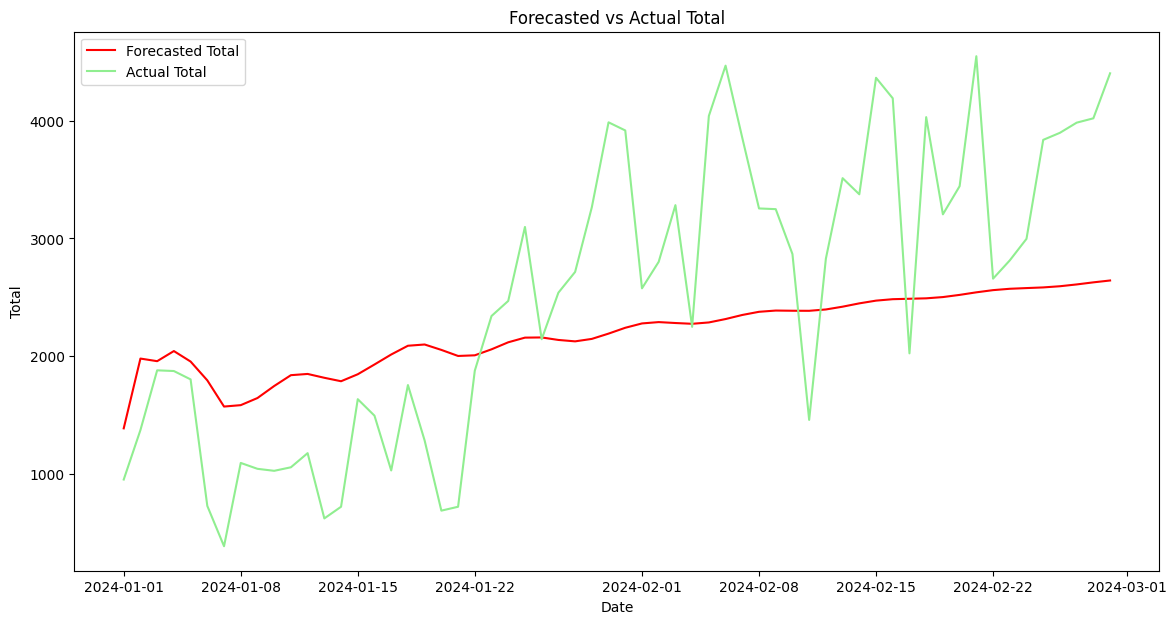

MSE: 1054143.0506185798, MAE: 863.8578017677361, RMSE: 1026.7146880309933


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# Load the data from the CSV file
df = pd.read_csv('./munich_erhardt.csv')

# Assuming 'Date' is the correct column after inspecting df.head()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Use relevant columns
df_var = df[['Total', 'AvgTemp', 'RainfallVolume']]

# Check for missing values
missing_values = df_var.isnull().sum()
print(missing_values)

# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series.dropna(), autolag='AIC')  # dropna() handles any NaN values that might affect the test
    print(f'  ADF Statistic: {result[0]}')
    print(f'  p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'  Critical Value {key}: {value}')
    
    if result[1] <= 0.05:
        print("  => P-value <= 0.05. The series is stationary.\n")
    else:
        print("  => P-value > 0.05. The series is not stationary.\n")

for col in df_var.columns:
    adf_test(df_var[col], title=col)

# Instantiate and fit the VAR model
model = VAR(df_var)
lag_order = model.select_order(maxlags=15)
optimal_lag = lag_order.aic
results = model.fit(optimal_lag)
print(results.summary())

# Forecasting
forecast_steps = 60  # Adjust this based on your needs
forecast = results.forecast(df_var.values[-optimal_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df_var.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=df_var.columns)
print(forecast_df)

# Load the January 2024 data without setting the 'Date' column as the index initially
df_2024 = pd.read_csv('munich2024.csv')

# Display the first few rows to inspect the column names
df_2024.head()

# Convert the 'Date' column to datetime and set it as the index
df_2024['Date'] = pd.to_datetime(df_2024['datum'])
df_2024.set_index('Date', inplace=True)

# Assuming 'gesamt' is the correct column after inspecting df_2024.head()
df_2024 = df_2024[['gesamt']]
df_2024.columns = ['Total']  # Rename the column to match the existing column name in the forecast_df

# Display the first few rows of the 2024 data
print(df_2024.head())

# Plot the forecasted values and the actual values
plt.figure(figsize=(14, 7))
plt.plot(forecast_df['Total'], label='Forecasted Total', color='red')
plt.plot(df_2024['Total'], label='Actual Total', color='lightgreen')
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Forecasted vs Actual Total')
plt.legend()
plt.show()


# Assuming you have actual values for the forecasted period, calculate error metrics
# Replace `actual_total` with your actual series
mse = mean_squared_error(df_2024['Total'], forecast_df['Total'])
mae = mean_absolute_error(df_2024['Total'], forecast_df['Total'])
rmse = mse ** 0.5
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')


## SARIMA

In [1]:
import pandas as pd

# Load the datasets
munich_erhardt_df = pd.read_csv('./munich_erhardt.csv')
munich2024_df = pd.read_csv('./munich2024.csv')


# Preprocess the training dataset
munich_erhardt_df['Date'] = pd.to_datetime(munich_erhardt_df['Date'])
munich_erhardt_preprocessed = munich_erhardt_df[['Date', 'Total']]

# Preprocess the testing dataset
munich2024_df['Date'] = pd.to_datetime(munich2024_df['Date'], format='%Y.%m.%d')
munich2024_preprocessed = munich2024_df[['Date', 'Total']]

# Display the first few rows of the preprocessed datasets
munich_erhardt_preprocessed.head(), munich2024_preprocessed.head()


(        Date   Total
 0 2011-07-25  1823.0
 1 2011-07-26  6167.0
 2 2011-07-27  6294.0
 3 2011-07-28  3943.0
 4 2011-07-29  3562.0,
         Date  Total
 0 2024-01-01    954
 1 2024-01-02   1374
 2 2024-01-03   1881
 3 2024-01-04   1875
 4 2024-01-05   1804)

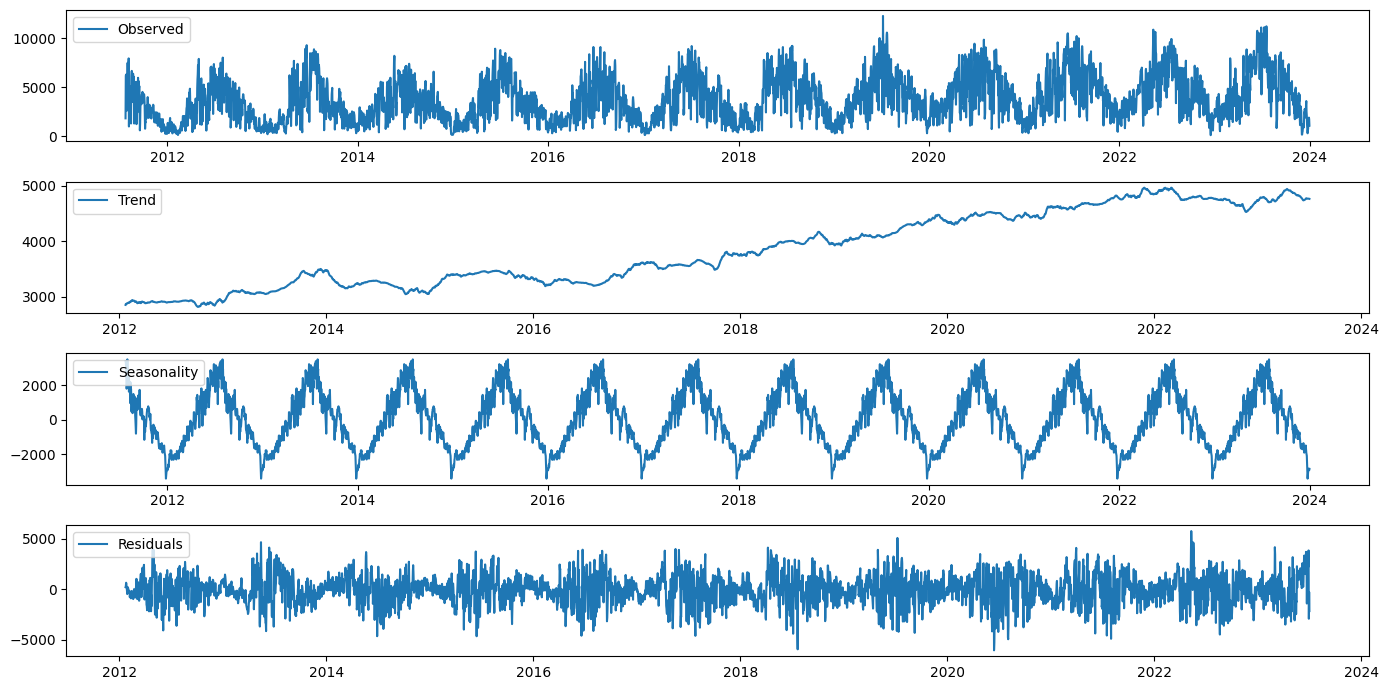

In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the Date column as the index
munich_erhardt_preprocessed.set_index('Date', inplace=True)

# Decompose the time series to observe trends and seasonality
decomposition = seasonal_decompose(munich_erhardt_preprocessed['Total'], model='additive', period=365)

# Plot the decomposed components of the time series
plt.figure(figsize=(14, 7))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()


In [3]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test to check stationarity
adf_test = adfuller(munich_erhardt_preprocessed['Total'].dropna())

# Display the ADF test results
adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4],
}

adf_result

{'Test Statistic': -4.4576142107782095,
 'p-value': 0.00023438394614298713,
 'Critical Values': {'1%': -3.4317998168351687,
  '5%': -2.8621806470517406,
  '10%': -2.5671110198147815}}

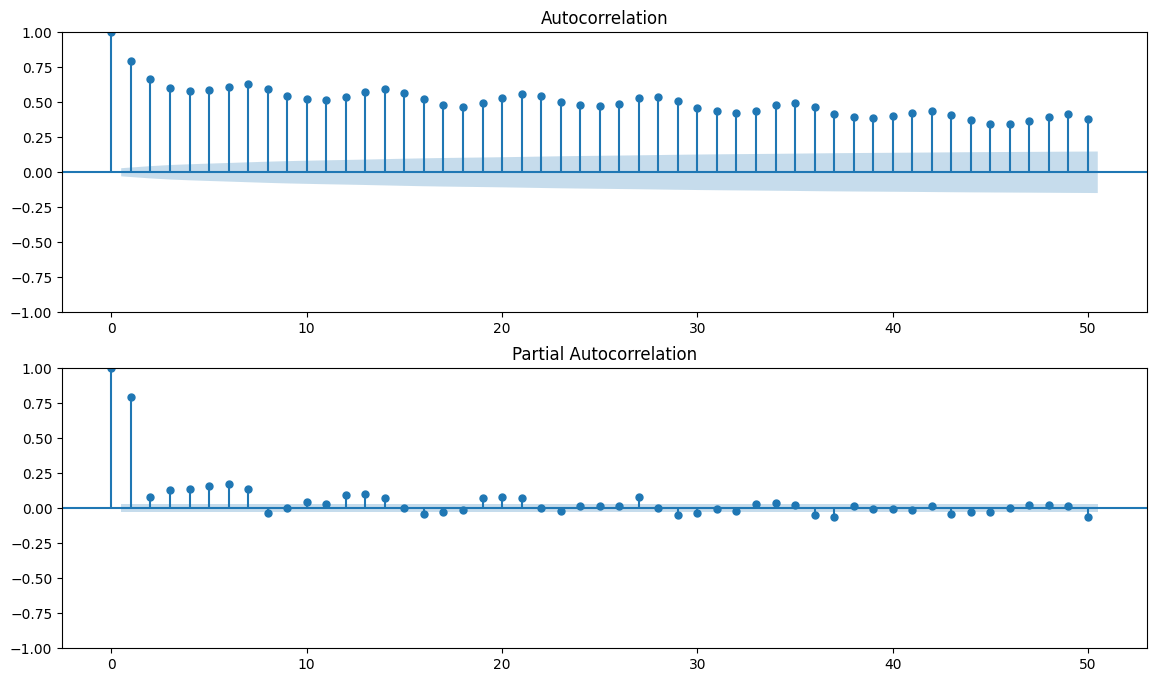

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots
fig, ax = plt.subplots(2,1, figsize=(14,8))

plot_acf(munich_erhardt_preprocessed['Total'], lags=50, ax=ax[0])
plot_pacf(munich_erhardt_preprocessed['Total'], lags=50, ax=ax[1], method='ywm')

plt.show()


In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Because of computational constraints, let's approximate the seasonal period to a smaller number
# We'll use a quarter of the year (approx. 91 days) to demonstrate the SARIMA fitting and forecasting
# This is a simplification for demonstration purposes only
seasonal_period = 91

# Fit the SARIMA model
sarima_model = SARIMAX(munich_erhardt_preprocessed['Total'],
                       order=(1, 0, 0),
                       seasonal_order=(1, 1, 1, seasonal_period),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

# Forecast for the next year (2024)
forecast_steps = len(munich2024_preprocessed)  # Number of days in 2024 for which we have data
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = munich2024_preprocessed.index
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Convert forecast to a DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast_mean.values}, index=forecast_index)
forecast_df['Lower CI'] = forecast_conf_int.iloc[:, 0].values
forecast_df['Upper CI'] = forecast_conf_int.iloc[:, 1].values

# Display the first few rows of the forecast DataFrame
forecast_df.head()


/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Forecast,Lower CI,Upper CI
0,2138.682208,-475.143200,4752.507616
1,3082.711962,-289.888012,6455.311936
2,3371.346280,-422.664388,7165.356949
3,3516.283995,-533.717921,7566.285912
4,3328.390214,-883.213047,7539.993474


## Holt-Winters Method

In [11]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Load the training dataset
training_data_path = './munich_erhardt.csv'
training_data = pd.read_csv(training_data_path)

# Load the testing dataset
testing_data_path = './munich2024.csv'
testing_data = pd.read_csv(testing_data_path)

# Prepare the training data: focusing on 'Date' and 'Total'
training_data['Date'] = pd.to_datetime(training_data['Date'])
training_series = training_data.set_index('Date')['Total']

# Fit the Holt-Winters model with an additive trend and additive seasonality
# Assuming daily data, let's consider a seasonal period of 365 days for annual seasonality
model = ExponentialSmoothing(training_series, trend="add", seasonal="add", seasonal_periods=365).fit()

# Prepare the testing data dates for prediction
testing_data['Date'] = pd.to_datetime(testing_data['Date'], format='%Y.%m.%d')
forecast_dates = testing_data['Date']

# Forecast the total counts for the testing data dates
predictions = model.forecast(len(forecast_dates))

# Convert predictions to a DataFrame for easier comparison
predictions_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Total': predictions.values})

predictions_df.head()

# Merge the forecasted totals with the actual totals from the testing dataset
comparison_df = pd.merge(predictions_df, testing_data[['Date', 'Total']], on='Date', how='left')
comparison_df.rename(columns={'Total': 'Actual_Total'}, inplace=True)

# Calculate the difference between forecasted and actual totals
comparison_df['Difference'] = comparison_df['Forecasted_Total'] - comparison_df['Actual_Total']

comparison_df.head()

/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Date,Forecasted_Total,Actual_Total,Difference
0,2024-01-01,1495.605963,954,541.605963
1,2024-01-02,1565.756820,1374,191.756820
2,2024-01-03,1415.630268,1881,-465.369732
3,2024-01-04,1661.604790,1875,-213.395210
4,2024-01-05,2105.818345,1804,301.818345


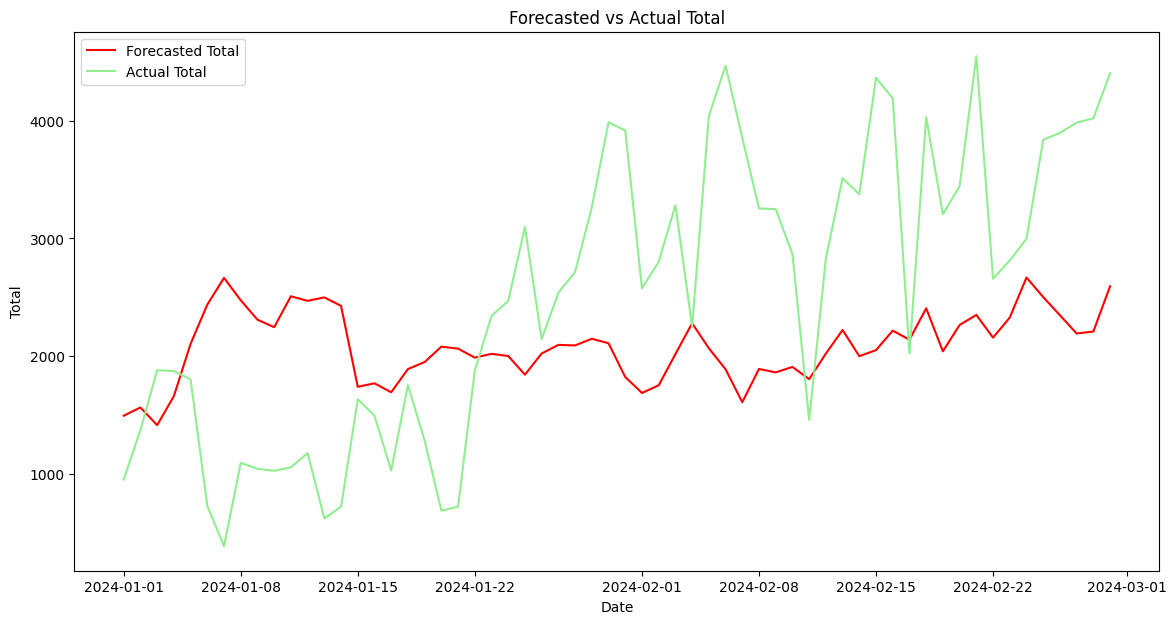

In [12]:
# plot the forecasted and actual values
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Forecasted_Total'], label='Forecasted Total', color='red')
plt.plot(comparison_df['Date'], comparison_df['Actual_Total'], label='Actual Total', color='lightgreen')
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Forecasted vs Actual Total')
plt.legend()
plt.show()



/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


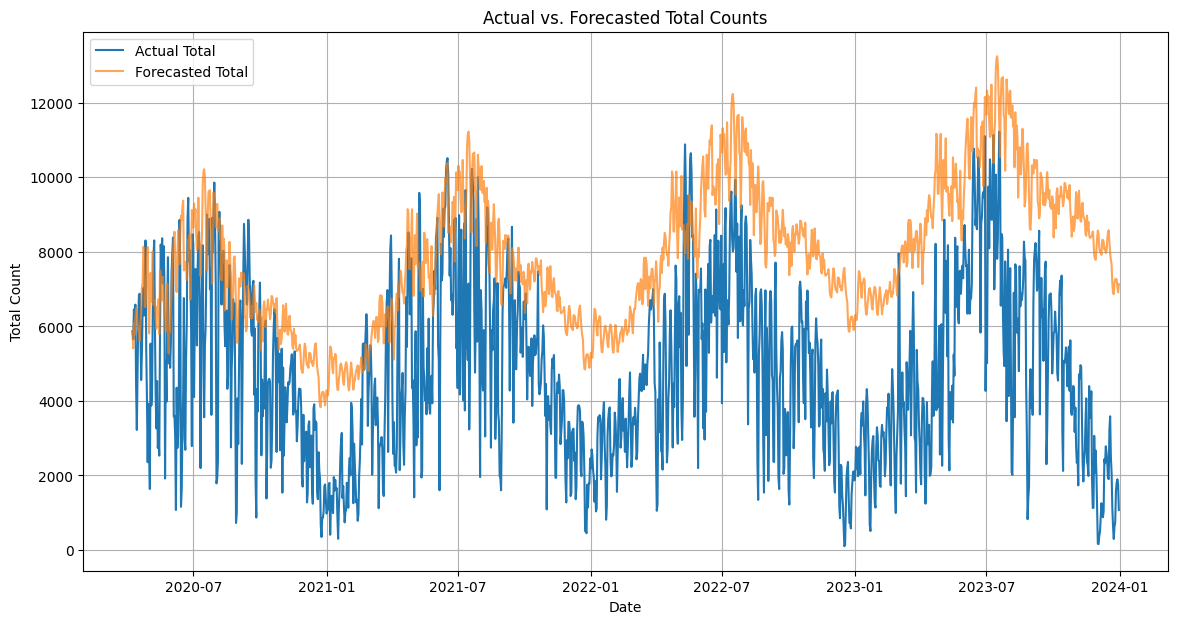

(None, (13951439.368949128, 3202.1649643732258, 3735.1625625866845))

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Determine the split point for 70% of the training data
split_point = int(len(training_series) * 0.7)

# Split the data into training and testing sets
training_set = training_series.iloc[:split_point]
testing_set = training_series.iloc[split_point:]

# Train the Holt-Winters model on the training set
model_split = ExponentialSmoothing(training_set, trend="add", seasonal="add", seasonal_periods=365).fit()

# Forecast the total counts for the testing set dates
predictions_split = model_split.forecast(len(testing_set))

# Convert the testing set and predictions to a DataFrame for easier comparison
comparison_split_df = pd.DataFrame({'Actual_Total': testing_set, 'Forecasted_Total': predictions_split})

# Calculate error metrics
mse = mean_squared_error(comparison_split_df['Actual_Total'], comparison_split_df['Forecasted_Total'])
mae = mean_absolute_error(comparison_split_df['Actual_Total'], comparison_split_df['Forecasted_Total'])
rmse = np.sqrt(mse)

# Plot the actual vs. forecasted total counts
plt.figure(figsize=(14, 7))
plt.plot(comparison_split_df['Actual_Total'], label='Actual Total')
plt.plot(comparison_split_df['Forecasted_Total'], label='Forecasted Total', alpha=0.7)
plt.title('Actual vs. Forecasted Total Counts')
plt.xlabel('Date')
plt.ylabel('Total Count')
plt.legend()
plt.grid(True)

plt.show(), (mse, mae, rmse)


## TCN

In [34]:
import pandas as pd
from datetime import datetime

# Load the training data
training_data_path = './munich_erhardt.csv'
training_data = pd.read_csv(training_data_path)
# Load the testing data
testing_data_path = './munich2024.csv'
testing_data = pd.read_csv(testing_data_path)

# Preprocessing training data: No major preprocessing needed beyond what's already discussed

# Preprocessing testing data
# Convert 'Date' format in testing data to match the training data format
testing_data['Date'] = pd.to_datetime(testing_data['Date'], format='%Y.%m.%d').dt.strftime('%Y-%m-%d')

# Selecting relevant columns (excluding 'bewoelkung' and 'sonnenstunden' for consistency with training data)
testing_data_relevant = testing_data[['Date', 'Total', 'MinTemp', 'MaxTemp', 'RainfallVolume']].copy()

# Display the first few rows of the adjusted testing dataset to verify changes
testing_data_relevant.head()

,Date,Total,MinTemp,MaxTemp,RainfallVolume
0,2024-01-01,954,3.3,7.1,0.0
1,2024-01-02,1374,3.0,11.1,1.0
2,2024-01-03,1881,7.1,13.0,1.6
3,2024-01-04,1875,4.3,9.1,0.0
4,2024-01-05,1804,2.2,8.6,12.7


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Feature engineering for dates
training_data['Date'] = pd.to_datetime(training_data['Date'])
testing_data_relevant['Date'] = pd.to_datetime(testing_data_relevant['Date'])

# Extract day of year as a cyclical feature
training_data['DayOfYear'] = training_data['Date'].dt.dayofyear
testing_data_relevant['DayOfYear'] = testing_data_relevant['Date'].dt.dayofyear

# Normalize weather conditions and day of year feature
features_to_scale = ['MinTemp', 'MaxTemp', 'RainfallVolume', 'DayOfYear']
scaler = StandardScaler()

# Fit on training data
training_data_scaled = scaler.fit_transform(training_data[features_to_scale])
training_data_scaled = np.concatenate([training_data_scaled, training_data[['Total']].values], axis=1)

# Transform testing data
testing_data_scaled = scaler.transform(testing_data_relevant[features_to_scale])
testing_data_scaled = np.concatenate([testing_data_scaled, testing_data_relevant[['Total']].values], axis=1)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_data_scaled[:, :-1], training_data_scaled[:, -1], test_size=0.2, random_state=42)

# Output the shapes of the datasets as a sanity check
X_train.shape, X_val.shape, testing_data_scaled.shape

((3634, 4), (909, 4), (60, 5))

Epoch 1/100
114/114 [==============================] - 0s 1ms/step - loss: 18990676.0000 - val_loss: 11005970.0000
Epoch 2/100
114/114 [==============================] - 0s 694us/step - loss: 3254879.5000 - val_loss: 1869398.0000
Epoch 3/100
114/114 [==============================] - 0s 723us/step - loss: 1842222.7500 - val_loss: 1683349.2500
Epoch 4/100
114/114 [==============================] - 0s 693us/step - loss: 1678050.3750 - val_loss: 1622383.2500
Epoch 5/100
114/114 [==============================] - 0s 752us/step - loss: 1602264.0000 - val_loss: 1598253.6250
Epoch 6/100
114/114 [==============================] - 0s 781us/step - loss: 1564934.6250 - val_loss: 1614428.7500
Epoch 7/100
114/114 [==============================] - 0s 747us/step - loss: 1541667.7500 - val_loss: 1643484.7500
Epoch 8/100
114/114 [==============================] - 0s 754us/step - loss: 1540212.6250 - val_loss: 1589430.6250
Epoch 9/100
114/114 [==============================] - 0s 652us/step - loss: 151

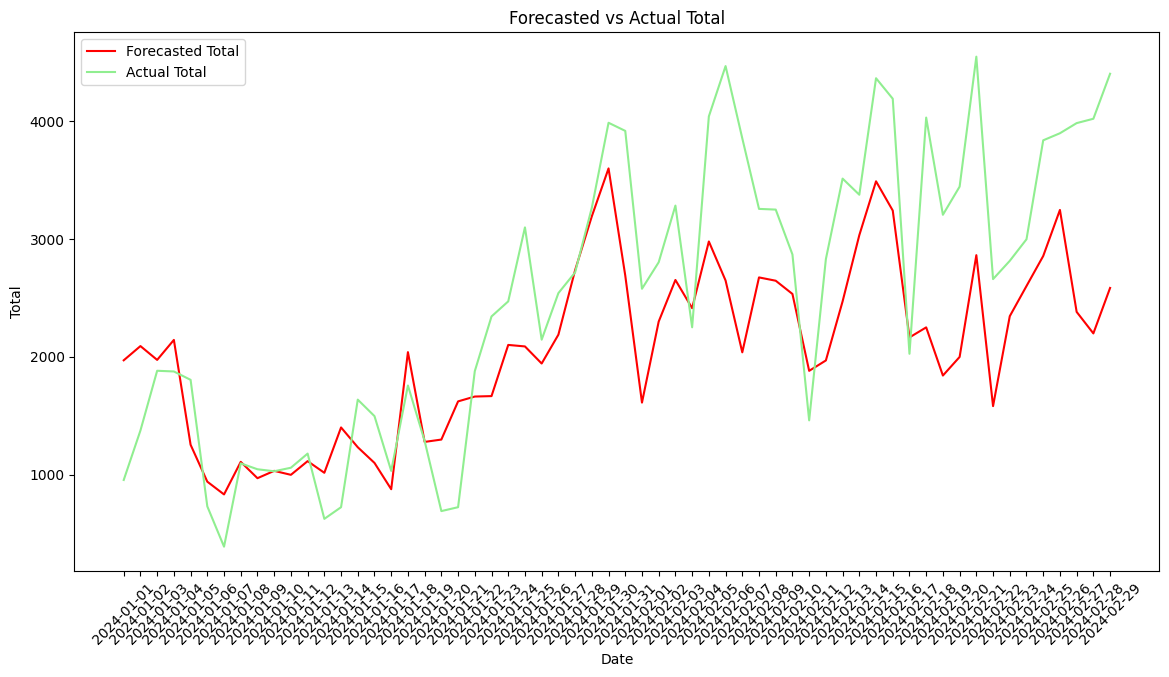

In [36]:
# Defining the TCN model
import tensorflow as tf
from tensorflow.keras import layers

def build_tcn_model(input_shape):
    i = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(i)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.Dense(1)(x)
    model = tf.keras.Model(i, x)
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the TCN model
model = build_tcn_model(input_shape=X_train.shape[1])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the testing data
test_loss = model.evaluate(testing_data_scaled[:, :-1], testing_data_scaled[:, -1])
test_loss

# Make predictions on the testing data
predictions = model.predict(testing_data_scaled[:, :-1])

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({'Date': testing_data_relevant['Date'], 'Forecasted_Total': predictions.flatten()})
predictions_df.head()

# Plot the forecasted and actual values
plt.figure(figsize=(14, 7))
plt.plot(predictions_df['Date'], predictions_df['Forecasted_Total'], label='Forecasted Total', color='red')
plt.plot(testing_data_relevant['Date'], testing_data_relevant['Total'], label='Actual Total', color='lightgreen')
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Forecasted vs Actual Total')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [38]:
# Calculate error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(testing_data_relevant['Total'], predictions_df['Forecasted_Total'])
mae = mean_absolute_error(testing_data_relevant['Total'], predictions_df['Forecasted_Total'])
rmse = np.sqrt(mse)

# Print the error metrics
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 732332.9326396552, MAE: 667.9102386474609, RMSE: 855.7645310712843
